In [1]:
'ADC to FFT withbaby - Blanket and Sunscreen'


'ADC to FFT withbaby - Blanket and Sunscreen'

# Loading the data

In [4]:
import gc
gc.collect()

0

In [6]:
%reset -f

In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [11]:
# Set directory containing CSV files
data_dir = r"D:\AIS & ML\Dataset_Input _Final\BlanketandSunscreen"

# Load all CSV files
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = [pd.read_csv(file, header=None) for file in csv_files]


In [12]:
# Combine all CSV data
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,64,32768,1,1,512,0,1953125,12,0.0,0,...,-7,-11,-11,-14,-15,-19,-21,-24,-23,-22
1,64,32768,1,1,512,0,1953125,12,0.0,0,...,45,47,44,43,41,38,37,35,31,29
2,64,32768,1,1,512,0,1953125,12,0.0,0,...,18,12,4,1,-5,-12,-17,-23,-26,-31
3,64,32768,1,1,512,0,1953125,12,0.0,0,...,-24,-31,-33,-28,-32,-36,-30,-26,-23,-20
4,64,32768,1,1,512,0,1953125,12,0.0,0,...,42,38,33,27,24,18,12,5,-2,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,64,32768,2,1,512,0,1953125,12,0.0,0,...,36,36,43,47,43,41,39,41,46,45
11996,64,32768,2,1,512,0,1953125,12,0.0,0,...,-13,-9,-13,-15,-21,-28,-27,-29,-32,-32
11997,64,32768,2,1,512,0,1953125,12,0.0,0,...,2,0,-1,-4,-10,-13,-16,-14,-16,-20
11998,64,32768,2,1,512,0,1953125,12,0.0,0,...,-24,-26,-29,-28,-31,-28,-25,-23,-21,-22


In [13]:
combined_df.shape

(12000, 16400)

In [14]:
adc_data = combined_df.iloc[:, 16:].values  # Extract ADC values (skip metadata columns)
adc_data
#print(f"Loaded data shape: {adc_data.shape}")  # Shape should be (num_samples, num_features)


array([[-17, -15, -16, ..., -24, -23, -22],
       [ 23,  18,  15, ...,  35,  31,  29],
       [-36, -36, -36, ..., -23, -26, -31],
       ...,
       [-25, -28, -27, ..., -14, -16, -20],
       [-19, -13, -10, ..., -23, -21, -22],
       [ 16,  17,  19, ...,  10,  11,  15]], shape=(12000, 16384))

In [15]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(signal, cutoff=30e3, fs=1e6, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

filtered_data = np.array([butter_lowpass_filter(row) for row in adc_data])
filtered_data

array([[  13.73385735,   80.0425241 ,  144.86313318, ...,  -20.73283188,
         -22.7905239 ,  -24.54550312],
       [ -11.84136201,  -51.85449989,  -89.79837956, ...,   39.64747584,
          39.34927001,   38.98669359],
       [ -25.17426039,   43.61776215,  112.16749108, ...,  -16.68683837,
         -20.24879657,  -23.40888734],
       ...,
       [ -43.94397597, -148.8206285 , -252.44928964, ...,  -13.97543577,
         -15.82978038,  -17.45945793],
       [ -61.35854111, -108.56342005, -153.14320243, ...,  -26.75273394,
         -27.18317827,  -27.49666553],
       [ -30.23614687,  -43.64107168,  -54.61037259, ...,    6.71189906,
           7.20392253,    7.70635557]], shape=(12000, 16384))

In [16]:
def calculate_snr(signal, noise):
    power_signal = np.mean(signal ** 2)
    power_noise = np.mean(noise ** 2)
    return 10 * np.log10(power_signal / power_noise)

snr_after = calculate_snr(filtered_data, adc_data - filtered_data)
print(f"SNR After Fixing: {snr_after:.2f} dB")

SNR After Fixing: 25.71 dB


In [18]:
# Select from the 17th column to the end
adc_data_selected_columns = filtered_data.mean(axis=1)  # Python uses 0-based indexing
adc_data_selected_columns

array([-2.30343651, 10.59912243, 19.56983599, ...,  4.66044386,
        4.59995074, 55.54122041], shape=(12000,))

# ADC to FFT Conversion

In [38]:
# Convert the pandas Series to a numpy array
adc_array = adc_data_selected_columns 

# Choose a window function - Hanning window in this case
window = np.hanning(len(adc_array))

# Apply the window function to your data
windowed_adc_data = adc_array * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_adc_data)

# Frequency bins (assuming you know the sampling rate)
sampling_rate = 1953125  # Example: 1000 Hz, replace with your actual sampling rate
min_freq = 35000  # 35 kHz
max_freq = 45000  # 45 kHz

n = len(adc_array)
freq = np.fft.fftfreq(n, d=1/sampling_rate)
# Calculate the magnitude and phase of the FFT result
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Create a DataFrame
fft_df = pd.DataFrame({
    'Frequency': freq,
    'FFT Magnitude': magnitude,
    'Phase': phase
})


fft_df.head()  # Display the first few rows of the DataFrame

,Frequency,FFT Magnitude,Phase
0,0.000000,46378.617052,0.000000
1,162.760417,22730.877556,-3.056708
2,325.520833,1213.847030,2.132477
3,488.281250,461.454602,2.500521
4,651.041667,788.183052,0.018248


In [40]:
# Add a new column to the fft_magnitude DataFrame for the binary label
# Set the value to 1 for presence of an infant with a carriage
fft_df['Infant_Presence'] = 1 # 1 for presence, 0 for absence (if you have such data)

# Display the first few rows to verify the new column
fft_df.head()

,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000000,46378.617052,0.000000,1
1,162.760417,22730.877556,-3.056708,1
2,325.520833,1213.847030,2.132477,1
3,488.281250,461.454602,2.500521,1
4,651.041667,788.183052,0.018248,1


In [42]:
len(fft_df)

12000

In [44]:
fft_df

,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000000,46378.617052,0.000000,1
1,162.760417,22730.877556,-3.056708,1
2,325.520833,1213.847030,2.132477,1
3,488.281250,461.454602,2.500521,1
4,651.041667,788.183052,0.018248,1
...,...,...,...,...
11995,-813.802083,708.186621,1.826979,1
11996,-651.041667,788.183052,-0.018248,1
11997,-488.281250,461.454602,-2.500521,1
11998,-325.520833,1213.847030,-2.132477,1


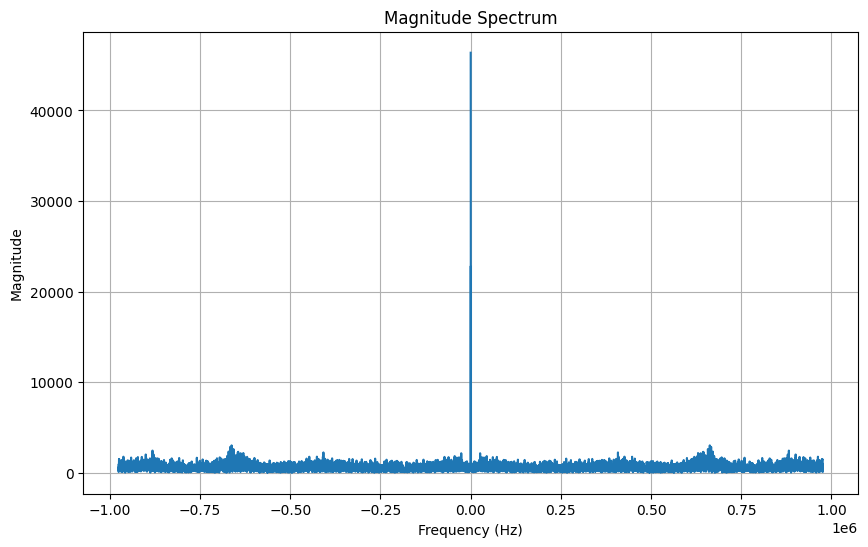

In [47]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(fft_df['Frequency'], fft_df['FFT Magnitude'])  # Plot positive frequency vs magnitude
plt.title('Magnitude Spectrum')  # Title of the plot
plt.xlabel('Frequency (Hz)')  # Label for the x-axis
plt.ylabel('Magnitude')  # Label for the y-axis
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot

# Saving to numpy array

In [49]:
numpy_array = fft_df.to_numpy()
# Save the array to a file
np.save('BabyCovered_with_Blanket_or_Sunscreen_npy_array_Lowpassfiltered_label.npy', numpy_array)

In [55]:
import gc
gc.collect()

0

In [53]:
%reset -f